In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lastfm import get_lastfm_genre

In [91]:
tracks_df = pd.read_csv('tracks.csv')
tracks_df.head()

,added_at,track_id,track_name,artist_id,artist_name,duration,explicit,popularity,album_type,album_id,album_name,album_release_date
0,2025-03-04T23:34:01Z,6ZRxnIHvjN0qTVRwz3PLtO,Smells Blood,4L0gz16xuM1as1OgYzh1SR,Kensuke Ushio,109280,False,56,album,05xPgo0O1tujgg6eDzIfxV,DEVILMAN crybaby (Original Soundtrack),2018-01-10
1,2025-03-04T18:52:29Z,4rk94uEZLJftdhnjp4Hwsx,Conflict,1ldNdtZX38LAsOk0ciLvb2,F.O.O.L,187527,False,32,single,6z5absG3SjLYPN8AhVcO0e,Revenger,2020-04-06
2,2025-03-04T18:47:34Z,0Obvb0dyqdOPyjWJJKMniU,Window Shop,7fVp0A6oCMfiQJihMnY0SZ,KNOWER,175208,False,29,album,7o5y1ttfkpL6zf6P2uCYPQ,Louis Cole and Genevieve Artadi,2010-10-01
3,2025-03-04T18:01:50Z,4MqJUXLycUCczH67JE06TA,Selecta 40',7wXSDFysHTrrNetXFfvTsF,NØKK,229714,False,8,single,3g3pfrt11jiC09HSLZKLBK,Selecta 40',2024-05-17
4,2025-03-03T17:04:51Z,1zhvxTuSha22nsUT5Nw8gE,15 Minutes,74KM79TiuVKeVCqs8QtB0B,Sabrina Carpenter,191519,True,79,album,3WzBIQmn2hrulLeTY9smkk,Short n' Sweet (Deluxe),2025-02-14


In [92]:
artists_df = pd.read_csv('artists.csv')
artists_df.head()

,id,artist_name,followers,genres,popularity
0,00CYRdkMnA0mwfy1VQPA7X,ellis,42857,future house,46
1,2f9PTWJfMMDTAFZcvHy1Z5,OVERWERK,143567,NaN,45
2,6UocZe4AprSYBvmn3J0oqY,Shiny Toy Guns,131298,electronic rock,42
3,3gk0OYeLFWYupGFRHqLSR7,Showtek,483101,hardstyle,62
4,5jdbH48Rcr1jvVSVG0osQK,DNVR,4687,bass house,26


In [93]:
# Gets missing genre information from lastfm and saves it as a CSV
# # print(merged_df[merged_df['genres'].isna()]['artist_name'].unique())
# na_genres_df = artists_df[artists_df['genres'].isna()]
# # na_genres_df = na_genres_df[na_genres_df['artist_name'].unique()]
# for index, row in na_genres_df.iterrows():
#     print(index, row['artist_name'])
#     if row['artist_name']:
#         genre = get_lastfm_genre(row['artist_name'])
#         if genre:
#             na_genres_df.loc[index, 'genres'] = genre
# na_genres_df.to_csv('artists_missing_genres.csv', index=False)


In [94]:
# Update with missing genres
missing_genres_df = pd.read_csv('artists_missing_genres.csv')
artists_merged_df = pd.merge(artists_df, missing_genres_df[['id', 'genres']],on='id', how='left')
artists_df['genres'] = artists_df['genres'].fillna(artists_merged_df['genres_y'])

# Clean genre strings
artists_df['genres'] = artists_df['genres'].astype(str)
artists_df['genres'] = [g.lower().replace('-',' ') for g in artists_df['genres']]

# Identify artists with unique genres to check for inaccuracies
genre_counts = artists_df['genres'].value_counts()
unique_genres = artists_df[artists_df['genres'].isin(genre_counts[genre_counts == 1].index)]
unique_genres.sort_values(by='genres')

,id,artist_name,followers,genres,popularity
133,75VKfyoBlkmrJFDqo1o2VY,Fireboy DML,3793349,afrobeats,71
309,5TOosZsVbwb5O1BOFdcLmw,Soul Coughing,136801,alternative rock,42
56,7ofG5BaSiQp8WeL4YCYDhF,adore,116181,ambient,66
44,6cK3NBO6uP7hh0oyuVELFl,Saweetie,2479904,better than selena gomez,68
248,4YrKBkKSVeqDamzBPWVnSJ,Basement Jaxx,551552,big beat,56
52,1dhLLX9IY5DD8uElJwjZFX,DJ Kuba,28183,big room,53
143,6o2D1YBpFJDDaMwZYGyW3T,Vana,107124,booba,55
246,0NGAZxHanS9e0iNHpR8f2W,Alok,11277902,brazilian bass,78
118,1bgWqGp78w6C8CNPvD6Qlo,FWLR,20675,canada,36
7,1QuMvIohbPqddOqTlACR47,The Myriad,4735,christian alternative rock,15


In [95]:
replace = pd.DataFrame({
    'artist_name': ['Saweetie', 'FWLR', 'gladde paling', 'ShogunF', 'Garrett Williamson', 'WHIPPED CREAM'],
    'genres': ['hip hop', 'bass house', 'memetechno', 'electronic', 'video game music', 'edm']
})
for a in replace['artist_name']:
    artists_df.loc[artists_df['artist_name'] == a,
                   'genres'] = replace.loc[replace['artist_name'] == a, 'genres'].values.item()

In [96]:
# Convert added at into date, time, and day of week
tracks_df['added_at'] = pd.to_datetime(tracks_df['added_at'])
tracks_df['added_at_date'] = tracks_df['added_at'].dt.date
tracks_df['added_at_time'] = tracks_df['added_at'].dt.time
tracks_df['added_at_dow'] = tracks_df['added_at'].dt.day_name()

# Convert release date into date
tracks_df['album_release_date'] = pd.to_datetime(tracks_df['album_release_date'], format='mixed')
tracks_df['release_year'] = tracks_df['album_release_date'].dt.year

# merge
artists_df= artists_df.rename(columns={'id': 'artist_id'})
merged_df = pd.merge(tracks_df, artists_df, on='artist_id')

# Clean dupicate columns
merged_df = merged_df.rename(columns={'popularity_x': 'track_popularity', 'popularity_y': 'artist_popularity', 'followers': 'artist_followers', 'artist_name_x':'artist_name'})
merged_df.drop(columns='artist_name_y', inplace=True)
merged_df.head()

,added_at,track_id,track_name,artist_id,artist_name,duration,explicit,track_popularity,album_type,album_id,album_name,album_release_date,added_at_date,added_at_time,added_at_dow,release_year,artist_followers,genres,artist_popularity
0,2025-03-04 23:34:01+00:00,6ZRxnIHvjN0qTVRwz3PLtO,Smells Blood,4L0gz16xuM1as1OgYzh1SR,Kensuke Ushio,109280,False,56,album,05xPgo0O1tujgg6eDzIfxV,DEVILMAN crybaby (Original Soundtrack),2018-01-10,2025-03-04,23:34:01,Tuesday,2018,138638,anime,57
1,2025-03-04 18:52:29+00:00,4rk94uEZLJftdhnjp4Hwsx,Conflict,1ldNdtZX38LAsOk0ciLvb2,F.O.O.L,187527,False,32,single,6z5absG3SjLYPN8AhVcO0e,Revenger,2020-04-06,2025-03-04,18:52:29,Tuesday,2020,88300,synthwave,46
2,2025-03-04 18:47:34+00:00,0Obvb0dyqdOPyjWJJKMniU,Window Shop,7fVp0A6oCMfiQJihMnY0SZ,KNOWER,175208,False,29,album,7o5y1ttfkpL6zf6P2uCYPQ,Louis Cole and Genevieve Artadi,2010-10-01,2025-03-04,18:47:34,Tuesday,2010,141041,experimental,41
3,2025-03-04 18:01:50+00:00,4MqJUXLycUCczH67JE06TA,Selecta 40',7wXSDFysHTrrNetXFfvTsF,NØKK,229714,False,8,single,3g3pfrt11jiC09HSLZKLBK,Selecta 40',2024-05-17,2025-03-04,18:01:50,Tuesday,2024,247,uk garage,7
4,2025-03-03 17:04:51+00:00,1zhvxTuSha22nsUT5Nw8gE,15 Minutes,74KM79TiuVKeVCqs8QtB0B,Sabrina Carpenter,191519,True,79,album,3WzBIQmn2hrulLeTY9smkk,Short n' Sweet (Deluxe),2025-02-14,2025-03-03,17:04:51,Monday,2025,20013528,pop,91


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Tuesday'),
  Text(1, 0, 'Monday'),
  Text(2, 0, 'Saturday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Sunday'),
  Text(5, 0, 'Wednesday'),
  Text(6, 0, 'Friday')])

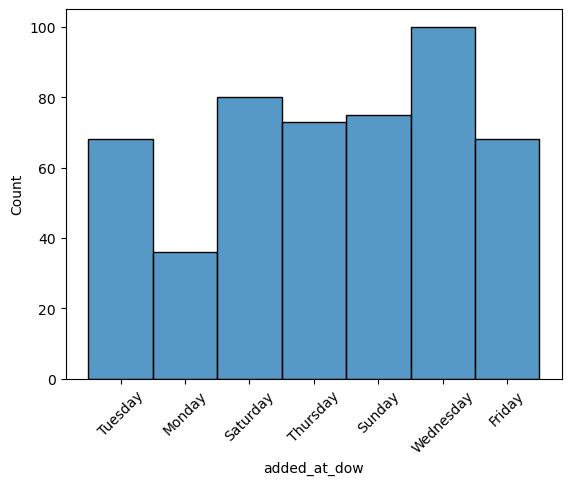

In [97]:
sns.histplot(tracks_df['added_at_dow'])
plt.xticks(rotation=45)

<Axes: xlabel='release_year', ylabel='Count'>

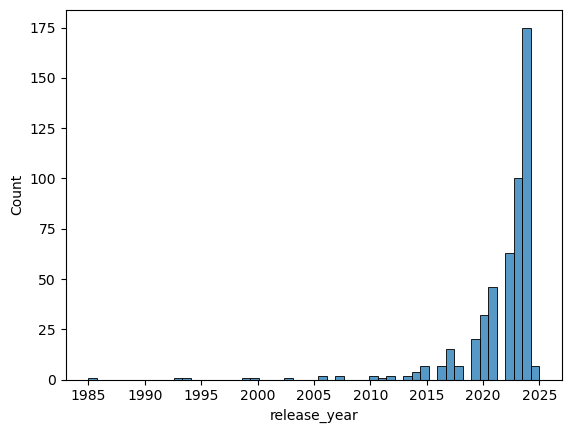

In [98]:
sns.histplot(merged_df['release_year'])

<Axes: xlabel='release_year', ylabel='popularity'>

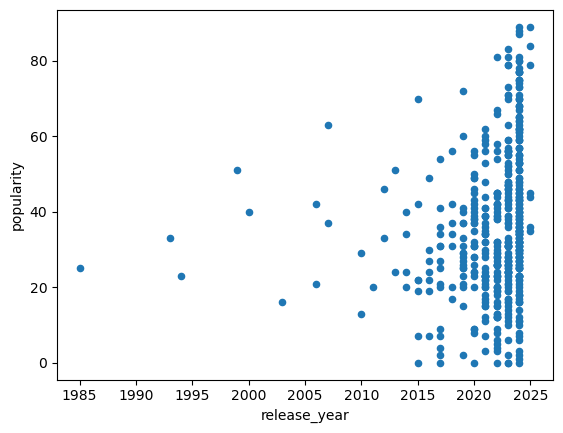

In [99]:
tracks_df.plot(y='popularity', x='release_year',kind='scatter')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [Text(0, 0, 'electronic'),
  Text(1, 0, 'breakcore'),
  Text(2, 0, 'dubstep'),
  Text(3, 0, 'bass house'),
  Text(4, 0, 'drum and bass'),
  Text(5, 0, 'synthwave'),
  Text(6, 0, 'pop'),
  Text(7, 0, 'hyperpop'),
  Text(8, 0, 'phonk'),
  Text(9, 0, 'nan'),
  Text(10, 0, 'future bass'),
  Text(11, 0, 'k pop'),
  Text(12, 0, 'speedcore'),
  Text(13, 0, 'house'),
  Text(14, 0, 'seen live'),
  Text(15, 0, 'edm'),
  Text(16, 0, 'riddim'),
  Text(17, 0, 'soundtrack'),
  Text(18, 0, 'bass music'),
  Text(19, 0, 'hip hop'),
  Text(20, 0, 'electro'),
  Text(21, 0, 'electro swing'),
  Text(22, 0, 'trance')])

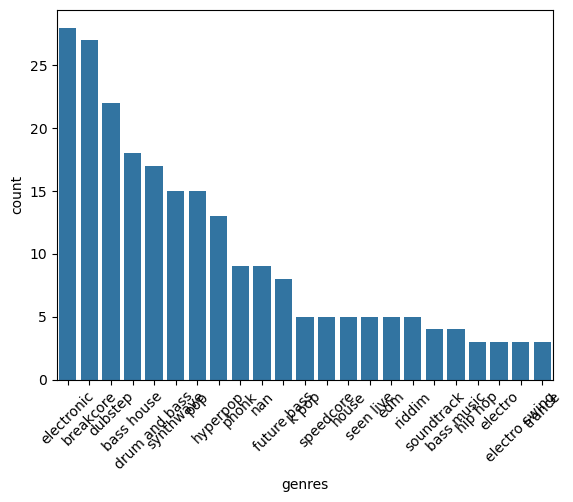

In [100]:
value_counts = artists_df['genres'].value_counts()
# filtered_genres = artists_df[artists_df['genres'].isin(value_counts[value_counts > 2].index)]
sns.barplot(value_counts[value_counts > 2])
plt.xticks(rotation=45)

In [106]:
artist_counts = tracks_df['artist_name'].value_counts()
artist_counts.head()

artist_name
Virtual Riot     17
REAPER           12
Charli xcx        9
Rezz              8
Chappell Roan     7
Name: count, dtype: int64

<Axes: xlabel='popularity', ylabel='Count'>

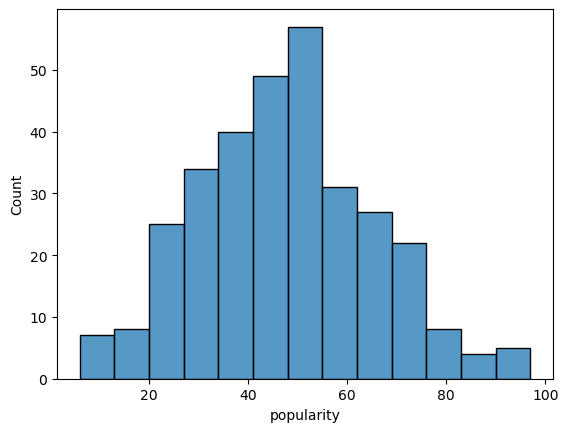

In [ ]:
sns.histplot(artists_df['popularity'])

<Axes: xlabel='popularity', ylabel='Count'>

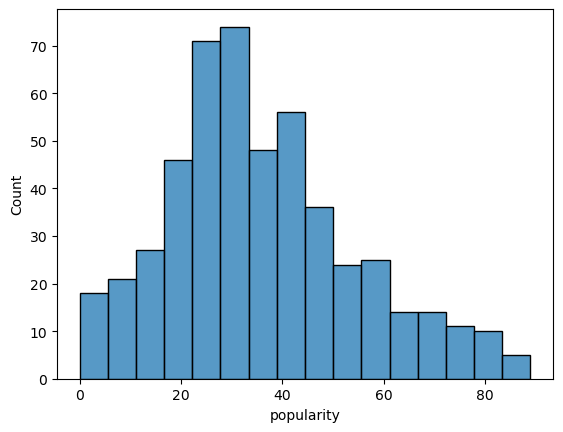

In [ ]:
sns.histplot(tracks_df['popularity'])

<Axes: xlabel='duration', ylabel='track_popularity'>

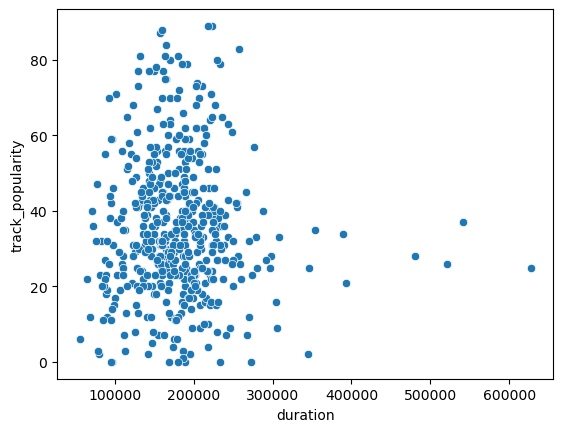

In [ ]:
sns.scatterplot(data=merged_df, x='duration', y='track_popularity')